### DATA 620 - Analysis of Bipartite Network (Project 2)

Author: Kory Martin  
Date: 3/10/2024

#### **1. Introduction**

#### Project Instructions

- Identify a large 2-node network dataset—you can start with a dataset in a repository. Your data should meet the criteria that it consists of ties between and not within two (or more) distinct groups.
- Reduce the size of the network using a method such as the island method described in chapter 4 of social network analysis.
- What can you infer about each of the distinct groups?
    

#### Project Plan

For this project, I chose to extend the work that I did on Assignment 3, using the a movieLens dataset [here](https://files.grouplens.org/datasets/movielens/ml-latest-small-README.html). In this project, I adjusted the way in which I constructed the network. 

Overview:
For this assignment, the network is constructed to represent the relationship between individual movie reviewers and the titles that they watched. Each network in the bipartite network represents a relationship between a user and the movie that they rated. Additionally, the ratings that they gave the movie is used as a weigth for the edges. Through this network structure, we can infer which movies are the most popular movies based on the number of individuals who watched them and by looking at the weighted edges - to get a representation of the ratings that they received.

As a recap, the network is constructed in the following manner:

- <b>Nodes</b>: This is a bipartite network with nodes representing **movie titles** and **movie reviewers**
- <b>Edges</b>: The edges in the bipartite network represent a relationship between a user and the movie if they reviewed that movie. Additionally, the edges are weighted based on the rating (from 0.5 to 5.0) that the user gave to that movie.


#### **2. Import Libraries**

We begin by importing the necessary libraries for use in the cleaning of our data, the generation of our network, and our visualization of the data.

In [66]:
import networkx as net
from networkx.algorithms import bipartite
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statistics import mean
import os.path
from plotnine import *

#### **3. Data Preparation**

We begin by importing the data for the movies in our dataset

In [2]:
movies_data = pd.read_csv('data/movies.csv')
ratings_data = pd.read_csv('data/ratings.csv')

In [3]:
movies_data.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [680]:
ratings_data.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Now that we have the movies and the ratings data imported, we will merge the two datasets so that we are able to track exactly which movie titles a specific user rated.

In [4]:
m1 = pd.merge(ratings_data, movies_data, how='left',
        left_on='movieId', right_on='movieId')

We now take our merged dataset and create a simplified version that only includes the movie title, the user ID and their rating for that movie

In [119]:
m1_simple = m1.loc[:,['title','userId','rating']]

In [681]:
m1_simple.head()

,title,userId,rating
0,Toy Story (1995),1,4.0
1,Grumpier Old Men (1995),1,4.0
2,Heat (1995),1,4.0
3,Seven (a.k.a. Se7en) (1995),1,5.0
4,"Usual Suspects, The (1995)",1,5.0


In order to generate a network that is mangeable, we will create a reduced dataset that is based on the following criteria:
- Only include users that have watched at least 1 but no more than 30 movies
- Only include movie titles that have been reviewed by 10 or more users

In [808]:
unique_users = m1_simple.groupby('userId').agg({'title':'count'}).reset_index().sort_values(by='title').query("title > 0 and title <= 30").userId.unique().tolist()

In [816]:
m1_simple_filtered = m1_simple.loc[m1_simple['userId'].isin(unique_users)]

In [823]:
unique_titles = m1_simple_filtered.groupby('title').agg({'userId':'count'}).reset_index().query('userId >= 10').title.unique().tolist()


Next we will use our limited list of users and movie titles to create a new dataset based on these filters

In [824]:
temp_df = m1_simple_filtered.loc[(m1_simple_filtered['title'].isin(unique_titles)) & (m1_simple_filtered['userId'].isin(unique_users))]

Finally, we will need to generate a new list of unique users and unique titles based on the combined set of users who watched 30 or fewer movies and the titles amongst these users that were watched by 10 or more users

In [825]:
unique_users = temp_df['userId'].unique().tolist()
unique_titles = temp_df['title'].unique().tolist()

Next we take our new filtered dataframe and create a data table that is comprised of the movie titles in the rows and the user ID in the columns. The values in this table are the movie ratings, and we will set any NA values (i.e. movies that were not reviewed) to a value of 0

In [826]:
user_movie_table = temp_df.pivot_table(index='title',columns='userId',values='rating',fill_value=0)

In [821]:
user_movie_table

userId,2,25,26,35,37,49,60,77,81,118,...,548,549,550,557,565,568,569,574,595,598
title,,,,,,,,,,,,,,,,,,,,,
Ace Ventura: Pet Detective (1994),0.0,0.0,3.0,0.0,5.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,4.0,3.0,0.0,4.0,5.0,0.0,0.0
Apollo 13 (1995),0.0,0.0,3.0,5.0,5.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,4.5,3.0,0.0,0.0,4.0,0.0,0.0
Batman (1989),0.0,0.0,4.0,4.0,3.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,3.0,3.0,0.0,0.0
Batman Forever (1995),0.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,3.0,2.0,...,0.0,0.0,0.0,0.0,2.0,0.0,5.0,3.0,0.0,0.0
Braveheart (1995),0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,3.0,0.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0
Dances with Wolves (1990),0.0,0.0,0.0,5.0,4.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,5.0,0.0,4.0,0.0,0.0,0.0
"Dark Knight, The (2008)",4.5,5.0,0.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,...,5.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Die Hard: With a Vengeance (1995),0.0,0.0,4.0,0.0,5.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,5.0,3.0,0.0,5.0,0.0,0.0,0.0
Dumb & Dumber (Dumb and Dumber) (1994),0.0,4.0,0.0,3.0,5.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,3.5,3.0,0.0,3.0,5.0,0.0,0.0


In [822]:
pd.crosstab(temp_df['title'],temp_df['userId'],margins=True)

userId,2,25,26,35,37,49,60,77,81,118,...,549,550,557,565,568,569,574,595,598,All
title,,,,,,,,,,,,,,,,,,,,,
Ace Ventura: Pet Detective (1994),0,0,1,0,1,0,0,0,1,0,...,0,0,1,1,0,1,1,0,0,13
Apollo 13 (1995),0,0,1,1,1,0,0,0,1,0,...,0,0,1,1,0,0,1,0,0,17
Batman (1989),0,0,1,1,1,0,0,0,1,0,...,0,0,0,1,0,1,1,0,0,15
Batman Forever (1995),0,0,1,0,1,0,0,0,1,1,...,0,0,0,1,0,1,1,0,0,14
Braveheart (1995),0,0,0,0,0,1,0,0,1,0,...,1,0,0,0,0,0,1,0,0,18
Dances with Wolves (1990),0,0,0,1,1,0,0,0,0,1,...,0,0,0,1,0,1,0,0,0,15
"Dark Knight, The (2008)",1,1,0,0,0,0,1,1,0,0,...,1,1,0,0,0,0,0,0,0,13
Die Hard: With a Vengeance (1995),0,0,1,0,1,0,0,0,1,0,...,0,0,1,1,0,1,0,0,0,11
Dumb & Dumber (Dumb and Dumber) (1994),0,1,0,1,1,0,0,0,1,0,...,0,0,1,1,0,1,1,0,0,11


Next we are going to use the table above to identify the edges that will be included in our network. We will only include edges where the user ranked a movie

In [827]:
rows = len(user_movie_table.index)
columns = len(user_movie_table.columns)

In [828]:
biadjacency_matrix = []

for i in range(rows):
    for j in range(columns):
        if user_movie_table.iloc[i,j] > 0:
            #mini_tupt = (i,user_movie_table.columns[j],user_movie_table.iloc[i,j])
            mini_tupt = (user_movie_table.index[i],user_movie_table.columns[j],user_movie_table.iloc[i,j])
            #print(mini_tupt)
            biadjacency_matrix.append(mini_tupt)

#### **4. Create network graph**

Now we have all the different components of the graph that are needed to build our network

In [829]:
G = net.Graph()

In [830]:
G.add_nodes_from(unique_titles,bipartite=0)
G.add_nodes_from(unique_users,bipartite=1)

In [831]:
G.add_weighted_edges_from(biadjacency_matrix)

We check to see if the graph was setup correctly, by checking that it is a bipartite graph and that it is a connected graph

In [832]:
net.is_bipartite(G)

True

In [833]:
net.is_connected(G)

True

Next we set the colors of the nodes such that the Movie Titles are <span style='color:red'>**red**</span> and the User ID nodes are in <span style='color:blue'>**blue**</span>

In [834]:
color = bipartite.color(G)


In [835]:
color_dict = {0:'b', 1:'r'}

In [836]:
color_list = [color_dict[i[1]] for i in color.items()]

In [921]:
node_weight = list(net.get_edge_attributes(G, 'weight'))

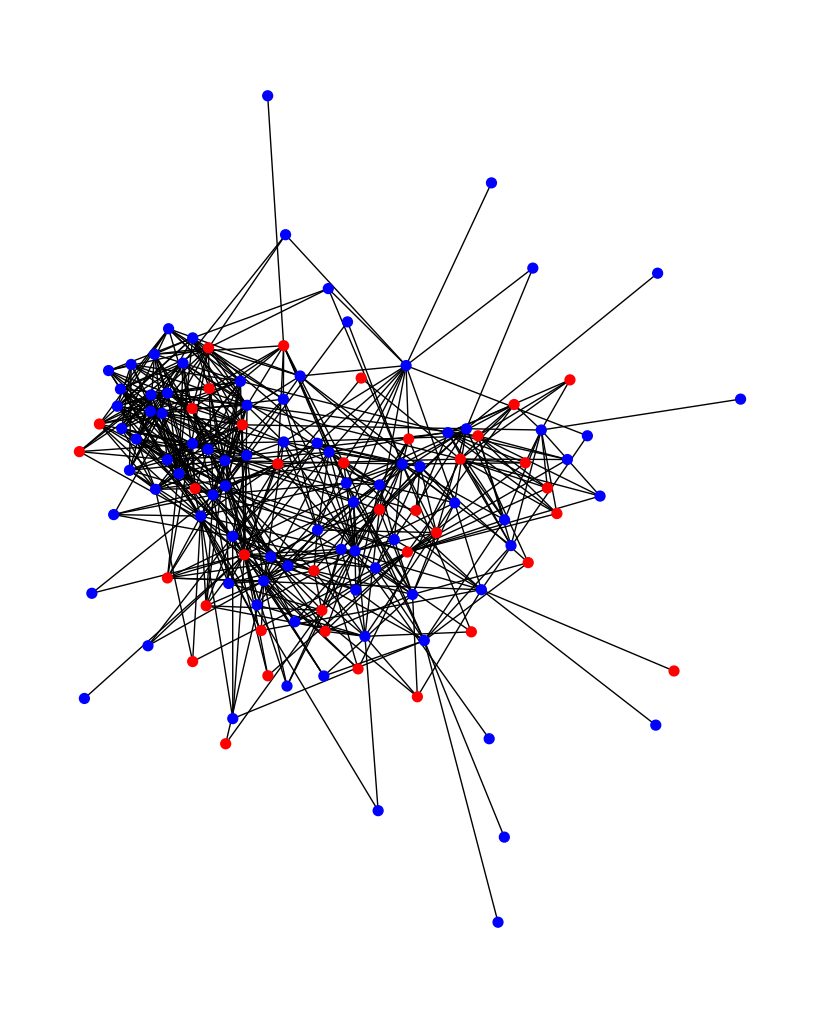

In [923]:
pos = net.spring_layout(G, seed=648)  # Seed layout for reproducible node positions
plt.figure(figsize=(8,10))
net.draw(G, pos,node_color=color_list, node_size=50)
plt.show()

#### **4.1 Functions for Island method**

Here we create the functions that we will use later to examine the islands in our projected graphs

In [838]:
def trim_edges(g, weight=1):
    g2 = net.Graph()
    for f,to, edata in g.edges(data=True):
        
        if edata['weight'] > weight:
            g2.add_edge(f,to,weight=edata['weight'])
    return g2

In [839]:
def island_method(g,iterations=5):
    weights = [edata['weight'] for f, to , edata in g.edges(data=True)]



    mn = int(min(weights))
    mx = int(max(weights))

    step = int((mx-mn)/iterations)

    return[[threshold,trim_edges(g,threshold)] for threshold in range(mn,mx,step)]
    

##### **5. Unique Users Projections**

We start by creating unweighted and weighted projections for the Users in the network. This projection represents the users that have the most movies in common with other users, since the edges in this projection would represent when two users have watched the same movie.

In [840]:
U1 = bipartite.projected_graph(G,unique_users)
U2 = bipartite.weighted_projected_graph(G,unique_users)

In [841]:
users_unweighted = pd.DataFrame([{'user':user,'degree':U1.degree(user)} for user in unique_users]).sort_values(by='degree', ascending=False).reset_index(drop=True)
users_weighted = pd.DataFrame([{'user':user,'degree':U2.degree(user,weight='weight')} for user in unique_users]).sort_values(by='degree', ascending=False).reset_index(drop=True)

#### **5.1 Top 10 Users based on number of connections**
Here we see the Top 10 users based on the number of connections they have with other users in the network that watched the same titles.

In [842]:
top_10 = users_unweighted.iloc[:10,:].copy().sort_values(by='degree')
top_10['user_cat'] = pd.Categorical(top_10.user, categories=pd.unique(top_10.user))

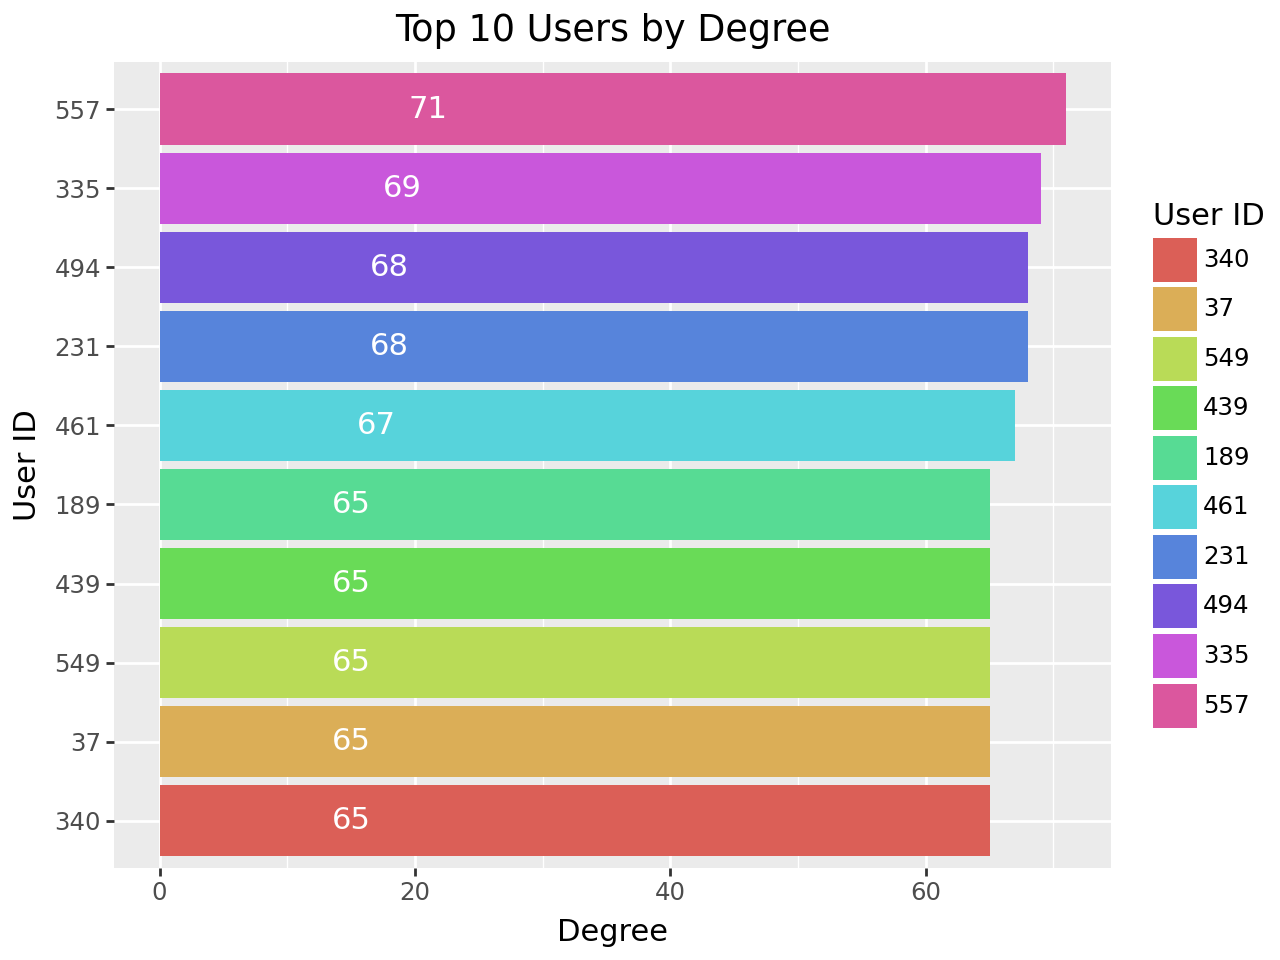

In [843]:
(
    ggplot(top_10)
    + aes(x='user_cat', y='degree', fill='user_cat')
    + geom_bar(stat='identity')
    + coord_flip()
    + labs(x='User ID', y='Degree', fill='User ID',title='Top 10 Users by Degree')
    + geom_text(aes(label='degree'),nudge_y=-50, color='white')
)

#### **5.2 Top Users based on weighted connections**

Here we see the Top 10 users based on the number of connections they have with other users in the network that watched the same titles.

In [844]:
top_10 = users_weighted.iloc[:10,:].copy().sort_values(by='degree')
top_10['user_cat'] = pd.Categorical(top_10.user, categories=pd.unique(top_10.user))

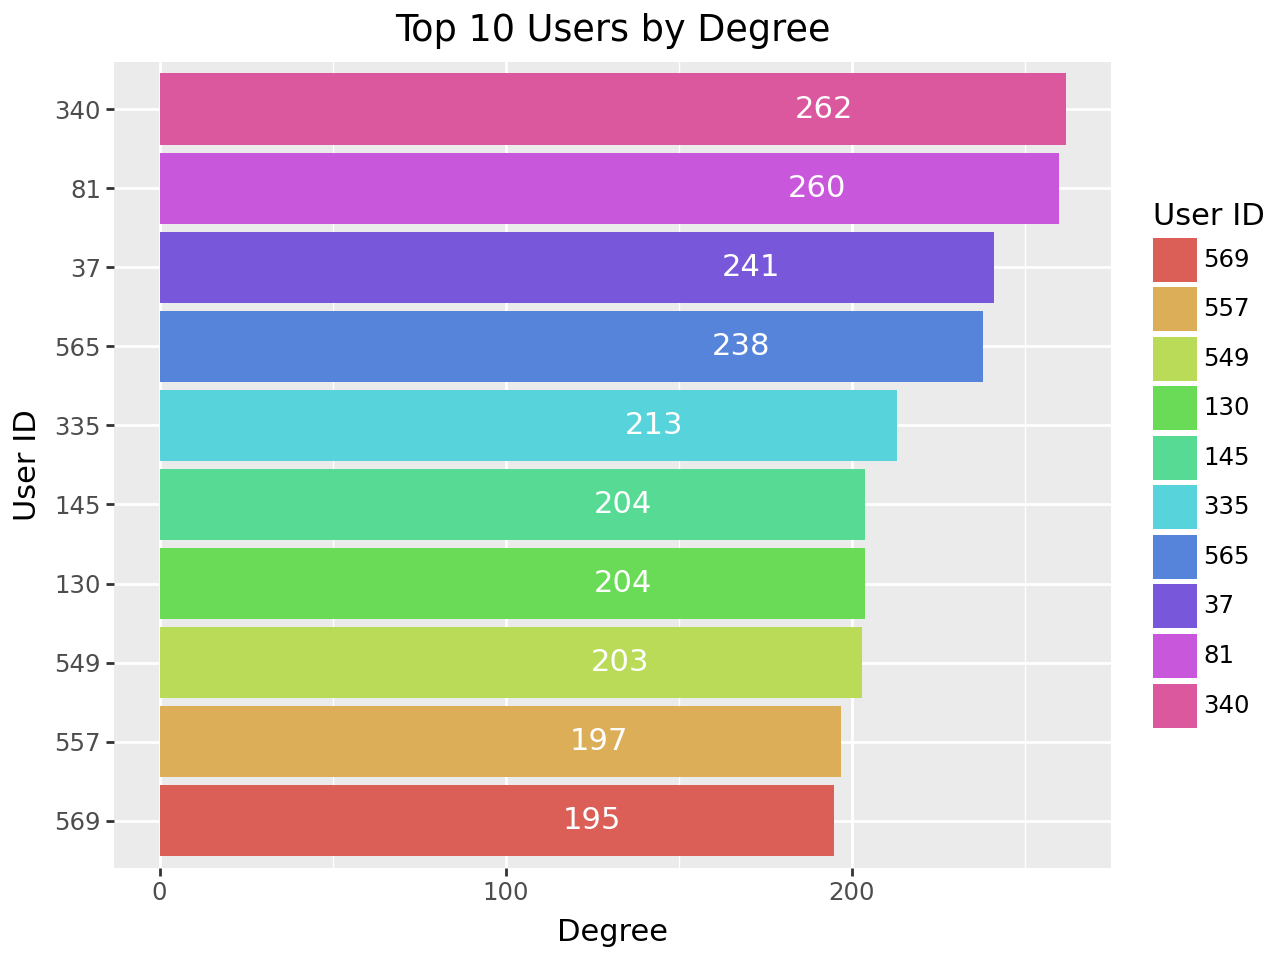

In [845]:
(
    ggplot(top_10)
    + aes(x='user_cat', y='degree', fill='user_cat')
    + geom_bar(stat='identity')
    + coord_flip()
    + labs(x='User ID', y='Degree', fill='User ID',title='Top 10 Users by Degree')
    + geom_text(aes(label='degree'),nudge_y=-70, color='white')
)

#### **5.3 Plot of unweighted user projection**

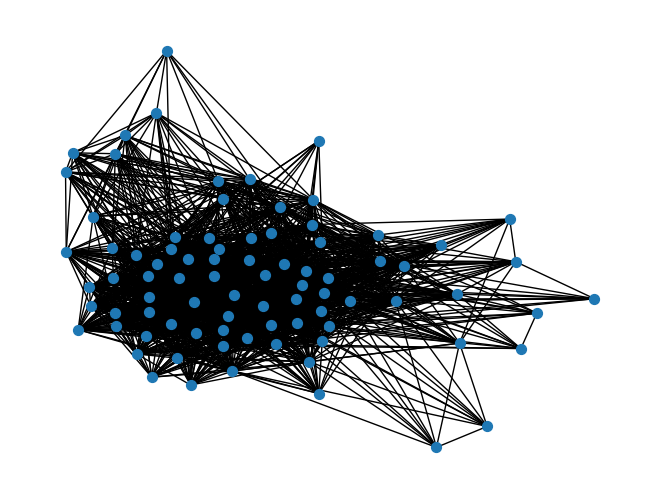

In [924]:
pos = net.spring_layout(U1, seed=648)  # Seed layout for reproducible node positions
net.draw(U1,pos,node_size=50)
plt.show()

#### 5.4 **Plot of weighted user projection**

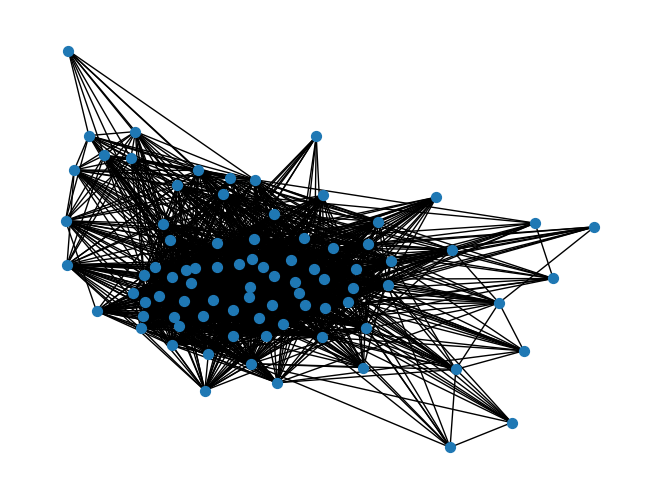

In [925]:
pos = net.spring_layout(U2, seed=648)  # Seed layout for reproducible node positions
net.draw(U2,pos,node_size=50)
plt.show()

#### **5.5 Island method**


We begin by running the island method on our Graph to identify specific sets of islandas in the network 

In [959]:
cc = U2.subgraph(next(net.connected_components(U2))).copy()

In [960]:
islands = island_method(cc)

In [961]:
for i in islands:
    #print(i[0],len(i[1]))
    print(i[0],len(i[1]),len(U.subgraph(next(net.connected_components(i[1])))))

1 74 74
3 57 48
5 37 34
7 21 5
9 13 13
11 7 7
13 2 2


#### **5.5.1 - Island #1**

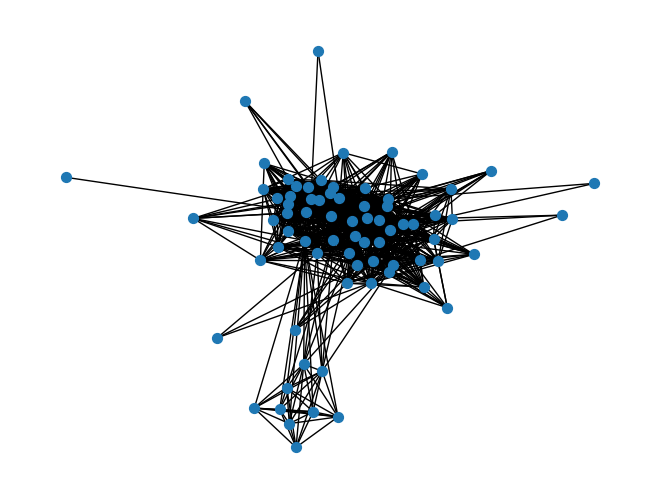

In [962]:
pos = net.spring_layout(islands[0][1], seed=648)  # Seed layout for reproducible node positions
net.draw(islands[0][1],pos,node_size=50)
plt.show()
#net.draw(islands[0][1])

#### **5.5.2 - Island #2**

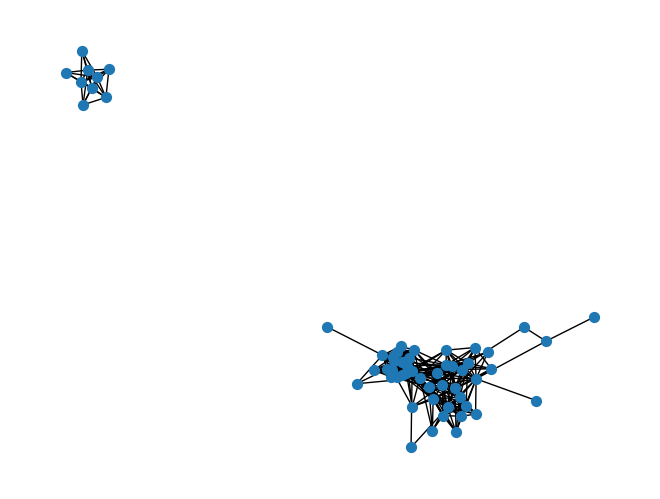

In [963]:
pos = net.spring_layout(islands[1][1], seed=648)  # Seed layout for reproducible node positions
net.draw(islands[1][1],pos,node_size=50)
plt.show()
#net.draw(islands[0][1])

#### **5.5.3 - Island #3**

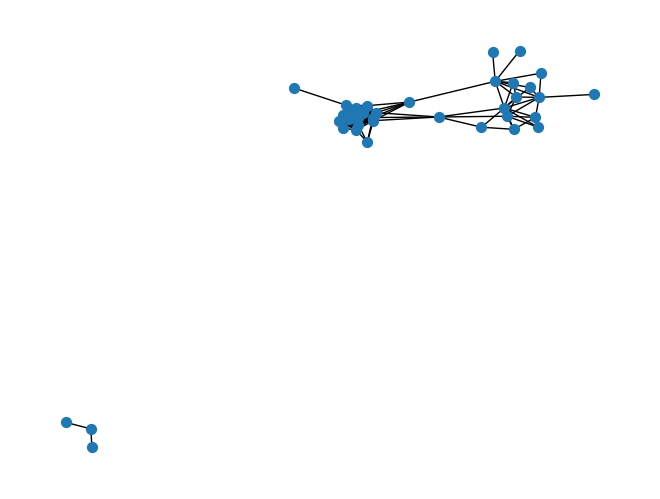

In [964]:
pos = net.spring_layout(islands[2][1], seed=648)  # Seed layout for reproducible node positions
net.draw(islands[2][1],pos,node_size=50)
plt.show()
#net.draw(islands[0][1])

#### **5.5.4 - Island #4**

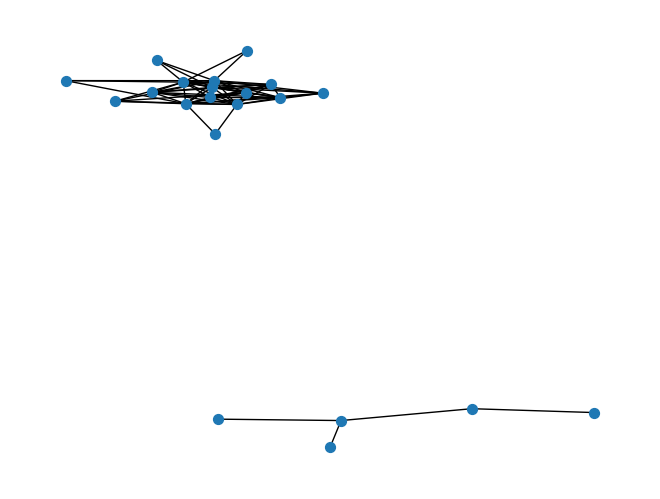

In [965]:
pos = net.spring_layout(islands[3][1], seed=648)  # Seed layout for reproducible node positions
net.draw(islands[3][1],pos,node_size=50)
plt.show()
#net.draw(islands[0][1])

#### **5.5.5 - Island #5**

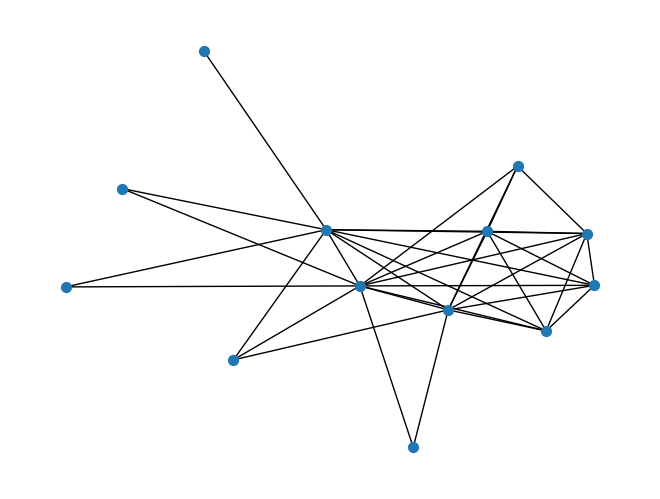

In [966]:
pos = net.spring_layout(islands[4][1], seed=648)  # Seed layout for reproducible node positions
net.draw(islands[4][1],pos,node_size=50)
plt.show()
#net.draw(islands[0][1])


#### **5.5.6 - Island #6**


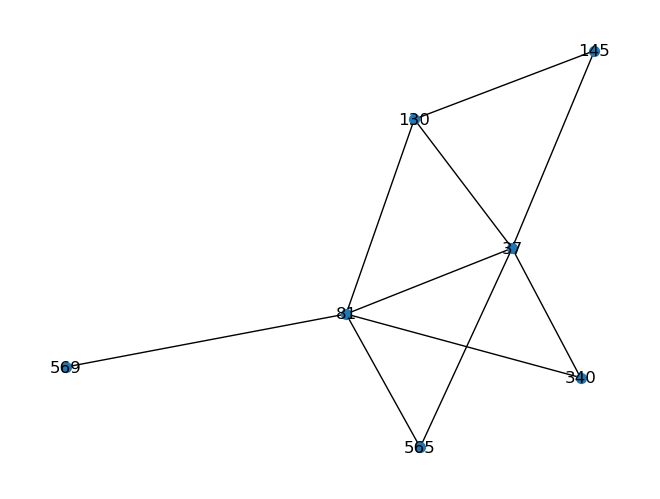

In [977]:
pos = net.spring_layout(islands[5][1], seed=648)  # Seed layout for reproducible node positions
net.draw(islands[5][1],pos,node_size=50, with_labels=True)
plt.show()
#net.draw(islands[0][1])


#### **5.5.7 - Island #7**

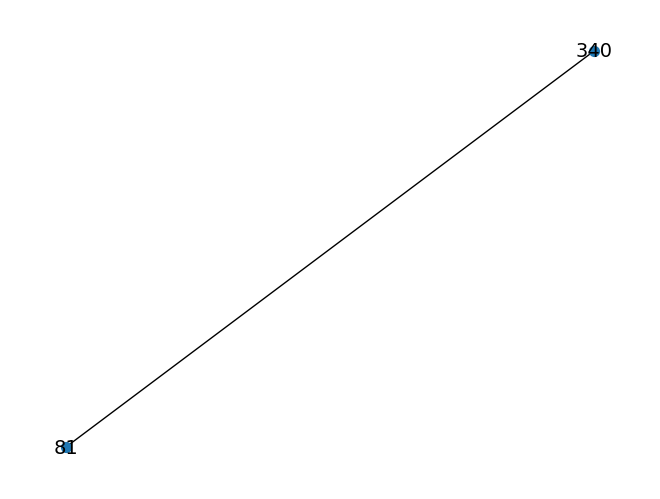

In [971]:
pos = net.spring_layout(islands[6][1], seed=648)  # Seed layout for reproducible node positions
net.draw(islands[6][1],pos,node_size=50,with_labels=True,font_size=14)
plt.show()
#net.draw(islands[0][1])

In [979]:
temp_df.loc[temp_df['userId'] == 569]

,title,userId,rating
88199,GoldenEye (1995),569,4.0
88200,"Usual Suspects, The (1995)",569,3.0
88201,Batman Forever (1995),569,5.0
88202,Die Hard: With a Vengeance (1995),569,5.0
88204,Dumb & Dumber (Dumb and Dumber) (1994),569,3.0
88205,Pulp Fiction (1994),569,5.0
88206,Stargate (1994),569,4.0
88207,Star Trek: Generations (1994),569,5.0
88208,Ace Ventura: Pet Detective (1994),569,4.0
88210,Forrest Gump (1994),569,3.0


#### **6. Movie Titles projection**

Next we are interested in looking at the projections of the bipartite network based on the movie titles.

In [804]:
T1 = bipartite.projected_graph(G,unique_titles)
T2 = bipartite.weighted_projected_graph(G,unique_titles)


In [805]:
titles_unweighted = pd.DataFrame([{'title':title,'degree':T1.degree(title)} for title in unique_titles]).sort_values(by='degree', ascending=False).reset_index(drop=True)
titles_weighted = pd.DataFrame([{'title':title,'degree':T2.degree(title,weight='weight')} for title in unique_titles]).sort_values(by='degree', ascending=False).reset_index(drop=True)

#### **6.1 Ranked movie titles (unweighted projection)**



##### **6.1.1 Top 10**
Here we see the Top 10 movie titles based on the number of users that watched that title. The list of top movies aren't really too suprising

In [896]:
top_10 = titles_unweighted.iloc[:10,:].copy().sort_values(by='degree')

In [897]:
top_10.iloc[:,:2].sort_values(by='degree', ascending=False)

,title,degree
0,Forrest Gump (1994),152
1,"Shawshank Redemption, The (1994)",151
2,Pulp Fiction (1994),150
3,"Silence of the Lambs, The (1991)",148
4,Braveheart (1995),148
5,Toy Story (1995),148
6,Schindler's List (1993),146
7,Terminator 2: Judgment Day (1991),142
8,"Usual Suspects, The (1995)",137
9,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),135



##### **6.1.2 Bottom 10**
Here we see the bottom 10 movie titles based on the number of users that watched that title.

In [902]:
bottom_10 = titles_unweighted.iloc[-10:,:].copy().sort_values(by='degree', ascending=False)

In [903]:
bottom_10.iloc[:,:2].sort_values(by='degree', ascending=False)

,title,degree
144,"Dark Knight Rises, The (2012)",60
145,"Good, the Bad and the Ugly, The (Buono, il bru...",60
146,Phenomenon (1996),59
147,Life Is Beautiful (La Vita è bella) (1997),58
148,"Time to Kill, A (1996)",57
149,City of God (Cidade de Deus) (2002),55
150,Almost Famous (2000),55
151,Avatar (2009),51
152,Harry Potter and the Half-Blood Prince (2009),49
153,Executive Decision (1996),47


I'm somewhat suprised to see the Harry Potter movie and Dark Knight Rises included in the list of the bottom 10 movies.

#### **6.2 Top 10 movie title (weighted projection)**

Here we see the Top 10 movie titles based on the number of connections and the rating that they received.

#### **6.2.1 Top 10**

In [904]:
top_10 = titles_weighted.iloc[:10,:].copy().sort_values(by='degree')

In [905]:
top_10.sort_values(by='degree', ascending=False)

,title,degree
0,"Shawshank Redemption, The (1994)",1640
1,Pulp Fiction (1994),1446
2,Forrest Gump (1994),1437
3,Braveheart (1995),1314
4,"Silence of the Lambs, The (1991)",1238
5,Apollo 13 (1995),1107
6,Batman (1989),1052
7,Dances with Wolves (1990),1041
8,Schindler's List (1993),990
9,Ace Ventura: Pet Detective (1994),988


When we consider the ratings that the movies received, we see a list of movies that one would consider to be a list of critically acclaimed movies.

#### **6.2.2 Bottom 10**

In [906]:
bottom_10 = titles_weighted.iloc[-10:,:].copy().sort_values(by='degree')

In [907]:
bottom_10.sort_values(by='degree', ascending=False)

,title,degree
144,Kill Bill: Vol. 1 (2003),129
145,City of God (Cidade de Deus) (2002),120
146,Butch Cassidy and the Sundance Kid (1969),120
147,"Good, the Bad and the Ugly, The (Buono, il bru...",116
148,Harry Potter and the Half-Blood Prince (2009),116
149,Armageddon (1998),115
150,Mystery Science Theater 3000: The Movie (1996),115
151,Avatar (2009),112
152,Life Is Beautiful (La Vita è bella) (1997),111
153,Almost Famous (2000),74


#### **6.3 Plot of movie connections (unweighted)**

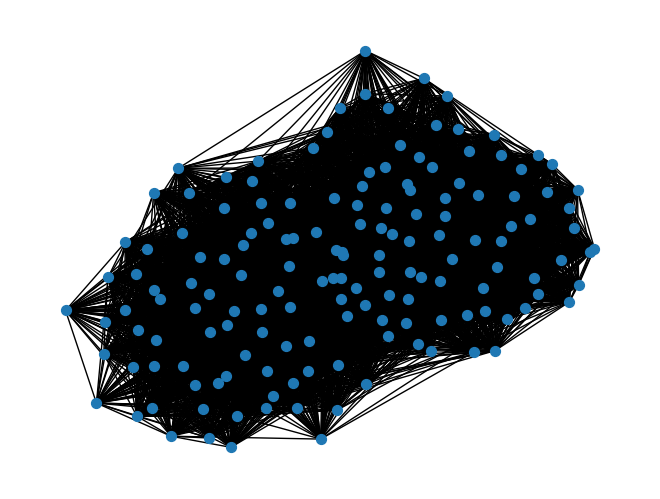

In [926]:
pos = net.spring_layout(T1, seed=648)  # Seed layout for reproducible node positions
net.draw(T1,pos,node_size=50)
plt.show()

#### **6.4 Plot of movie connections (weighted projection)**

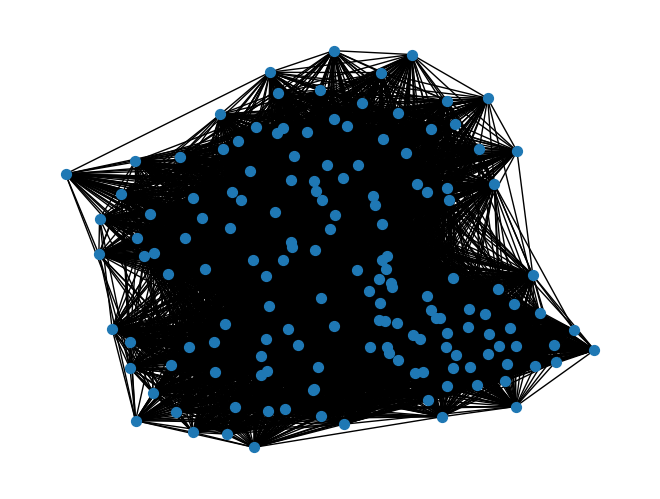

In [927]:
pos = net.spring_layout(T2, seed=648)  # Seed layout for reproducible node positions
net.draw(T1,pos,node_size=50)
plt.show()

#### **6.5 Island method**


We begin by running the island method on our Graph to identify specific sets of islandas in the network 

In [864]:
cc = T2.subgraph(next(net.connected_components(T2))).copy()

In [865]:
islands = island_method(cc)

In [892]:
for i in islands:
    #print(i[0],len(i[1]))
    print(i[0],len(i[1]),len(T2.subgraph(next(net.connected_components(i[1])))))

1 154 154
10 92 92
19 40 37
28 17 17
37 4 4


#### **6.5.1 - Island #1**

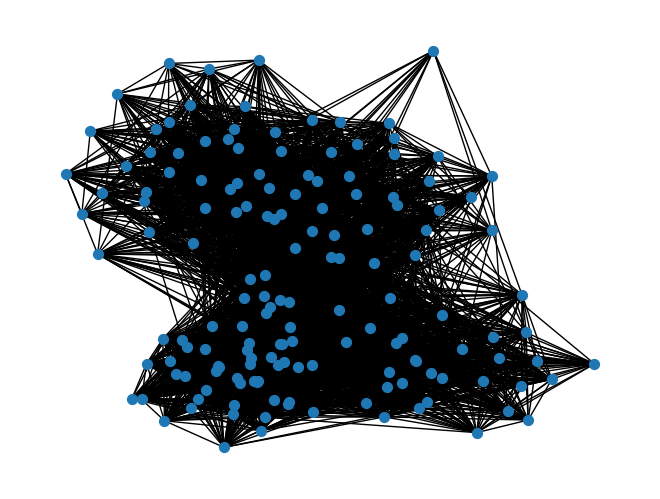

In [940]:
pos = net.spring_layout(islands[0][1], seed=648)  # Seed layout for reproducible node positions
net.draw(islands[0][1],pos,node_size=50)
plt.show()
#net.draw(islands[0][1])

#### **6.5.2 - Island #2**

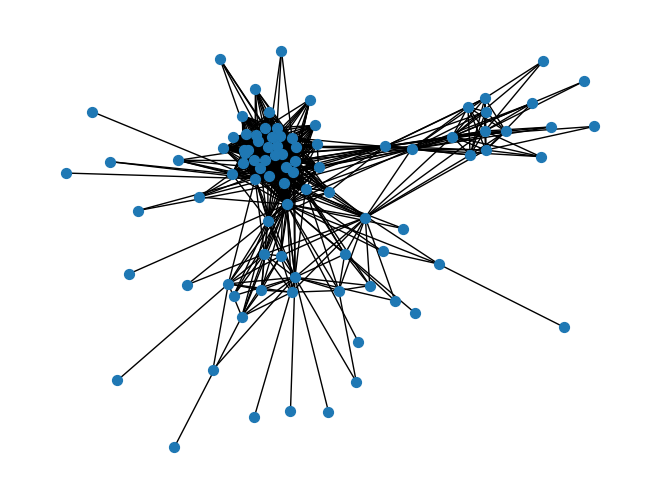

In [941]:
pos = net.spring_layout(islands[1][1], seed=648)  # Seed layout for reproducible node positions
net.draw(islands[1][1],pos,node_size=50)
plt.show()
#net.draw(islands[1][1])

#### **6.5.3 - Island #3**

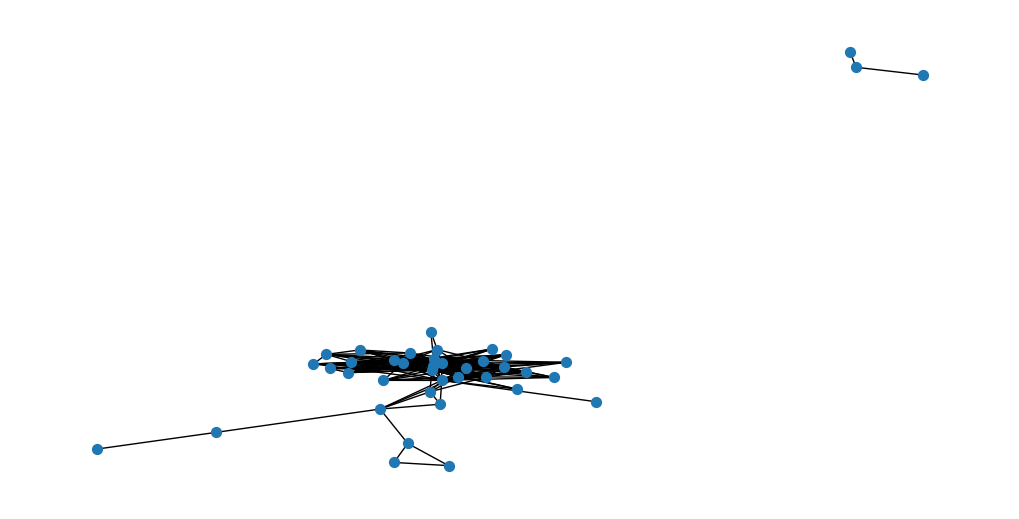

In [958]:
plt.figure(figsize=(10,5))
pos = net.spring_layout(islands[2][1], seed=648)  # Seed layout for reproducible node positions
net.draw(islands[2][1],pos,node_size=50)
plt.show()
#net.draw(islands[2][1])

#### **6.5.4 - Island #4**

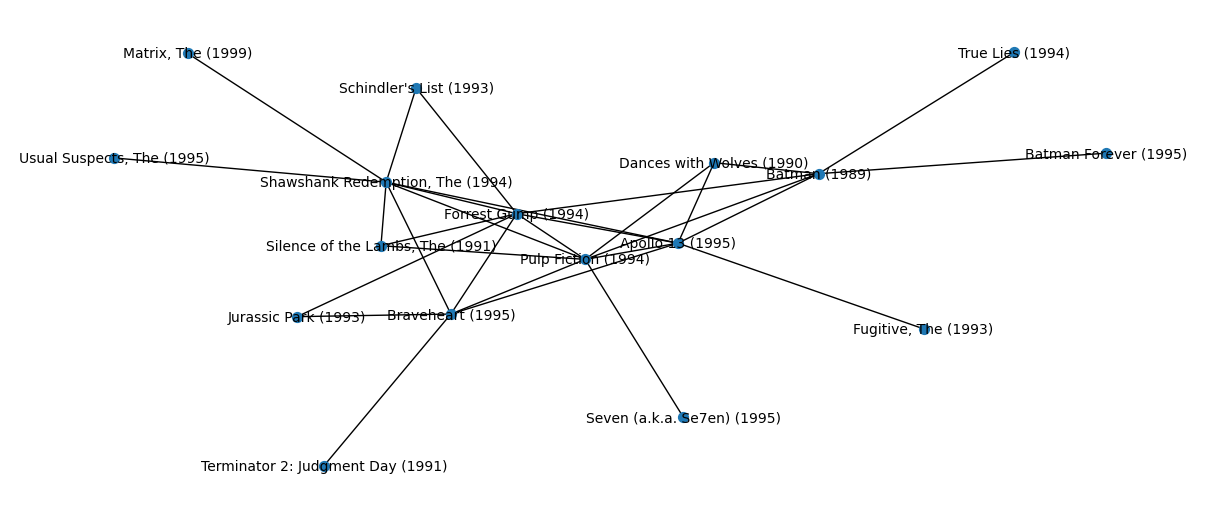

In [952]:
plt.figure(figsize=(12,5))
pos = net.spring_layout(islands[3][1], seed=648)  # Seed layout for reproducible node positions
net.draw(islands[3][1],pos,node_size=50,with_labels=True,font_size=10)
plt.show()
#net.draw(islands[3][1])

#### **6.5.5 - Island #5**

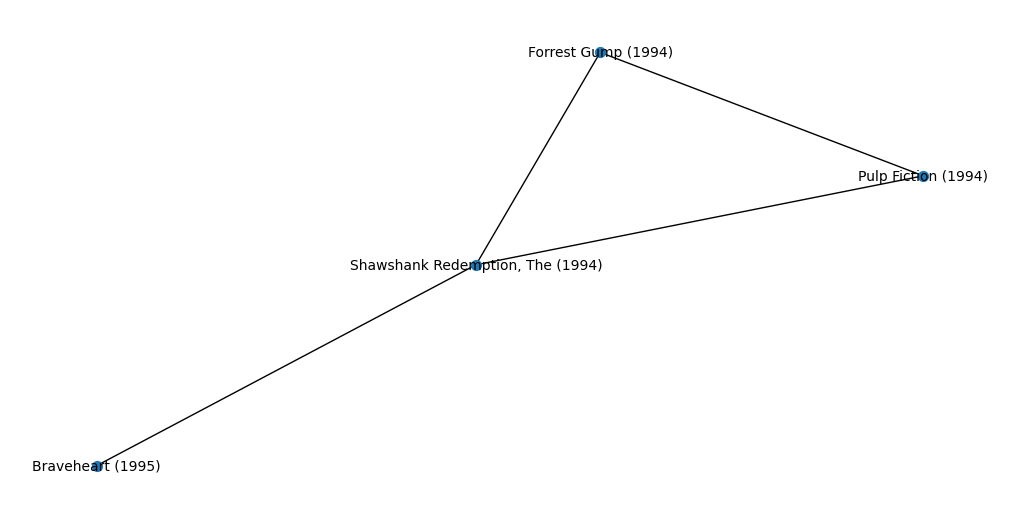

In [953]:
plt.figure(figsize=(10,5))
pos = net.spring_layout(islands[4][1], seed=648)  # Seed layout for reproducible node positions
net.draw(islands[4][1],pos,node_size=50,with_labels=True,font_size=10)
plt.show()
#net.draw(islands[4][1])

#### **7. Conclusion**



In this network, we find similar results as when we analyzed the network based on the eigenvector and degree centrality measures. The top movies in the network are titles that we would expect based on our own familiarity with movies. Looking at the Island network with weight of 34 (meaning there are at least 34 connections), we find that the network consists only of **Forrest Gump, Pulp Fiction, Shawshank Redemption and Braveheart**. Three of these four films together create a closed triad, with Shawshank Redemption serving as a connector to the movie Braveheart. From a personal perspective this fits into my own movie watching reality. I've seen Forrest Gump, Pulp Fiction and Shawshank Redemption; but I have not seen Bravehart. 